In [1]:
%load_ext autoreload
%autoreload 2
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
from juligrad import ops, tensor, optim, nn
import numpy as np

## Create half moon dataset

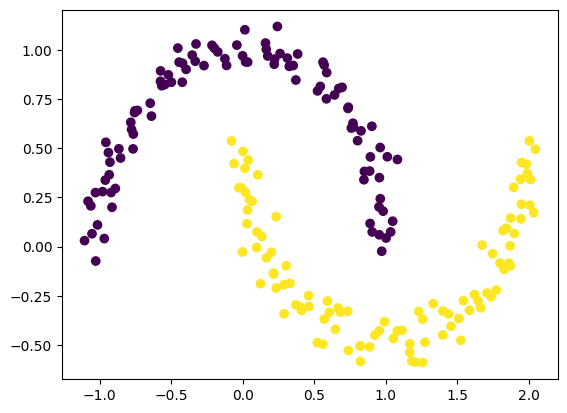

In [2]:
X, y = make_moons(n_samples=200, noise=0.06)
X, y = tensor.Tensor.fromNumpy(X, requiresGrad = False), tensor.Tensor.fromNumpy(y[:,None], requiresGrad=False)
plt.scatter(x=X.numpy()[:,0], y=X.numpy()[:,1], c=y.numpy())

## Logistic regression

Accuracy: 0.88


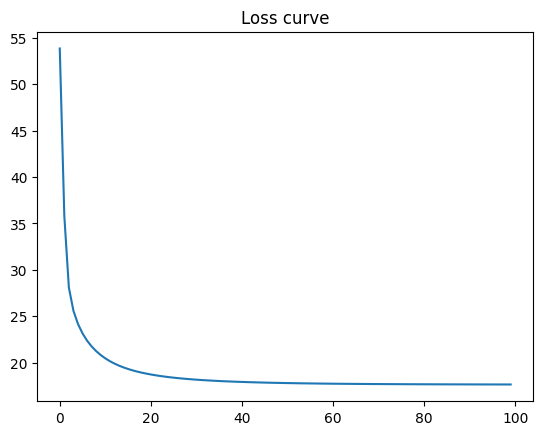

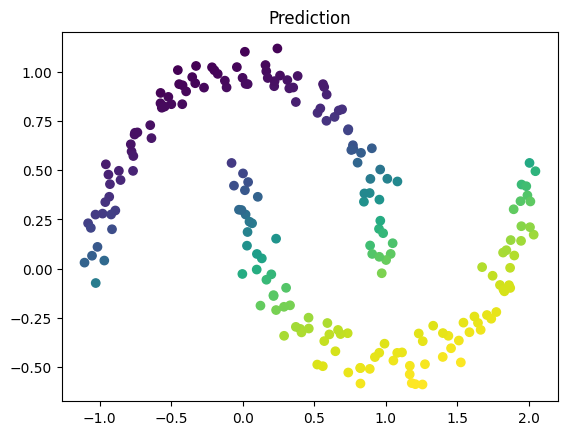

In [4]:
W = tensor.Tensor.uniform(size = (2,1))
b = tensor.Tensor.uniform(size = (1,1))
optimizer = optim.SGD(params=[W,b], lr=1e-2)
nEpoch = 100
lossHist = []
for i in range(nEpoch):
    optimizer.zeroGrad()
    pred = (X @ W + b.expand(repeats = X.shape[0], dim=0)).sigmoid()
    loss = ((y-pred)**2).sum()
    lossHist.append(loss.numpy())
    loss.backward()
    optimizer.step()

plt.plot(lossHist);plt.title('Loss curve');

pred = (X @ W + b.expand(repeats = X.shape[0], dim=0)).sigmoid()
acc = (pred.data.round() == y.data).sum()/y.shape[0]

print(f"Accuracy: {acc}")
plt.figure(); plt.scatter(x=X.numpy()[:,0], y=X.numpy()[:,1], c=pred.data); plt.title('Prediction');

Accuracy: 0.885


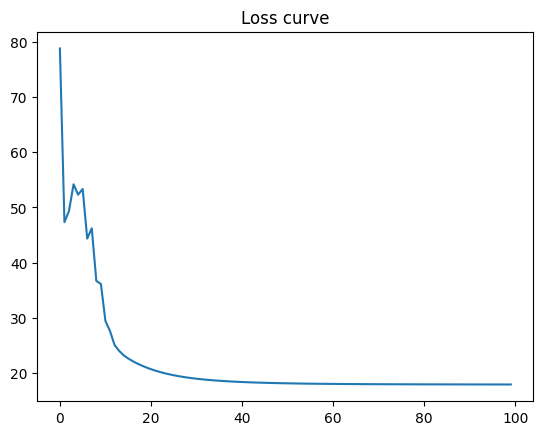

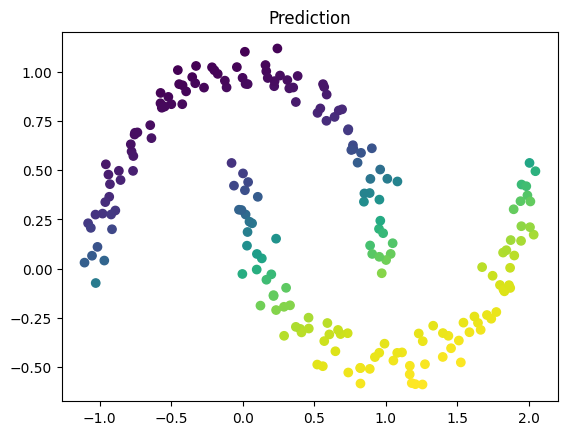

In [5]:
W1 = tensor.Tensor.uniform(size = (2,5))
b1 = tensor.Tensor.uniform(size = (1,5))
W2 = tensor.Tensor.uniform(size = (5,1))
b2= tensor.Tensor.uniform(size = (1,1))

optimizer = optim.SGD(params=[W1,b1, W2, b2], lr=1e-2)
nEpoch = 100
lossHist = []
for i in range(nEpoch):
    optimizer.zeroGrad()
    hidden = (X @ W1 + b1.expand(repeats = X.shape[0], dim=0)).sigmoid()
    pred = (hidden @ W2 + b2.expand(repeats = hidden.shape[0], dim=0)).sigmoid()
    loss = ((y-pred)**2).sum()
    lossHist.append(loss.numpy())
    loss.backward()
    optimizer.step()

plt.plot(lossHist);plt.title('Loss curve');

hidden = (X @ W1 + b1.expand(repeats = X.shape[0], dim=0)).sigmoid()
pred = (hidden @ W2 + b2.expand(repeats = hidden.shape[0], dim=0)).sigmoid()
acc = (pred.data.round() == y.data).sum()/y.shape[0]

print(f"Accuracy: {acc}")
plt.figure(); plt.scatter(x=X.numpy()[:,0], y=X.numpy()[:,1], c=pred.data); plt.title('Prediction');

## Using nn modules

Accuracy: 1.0


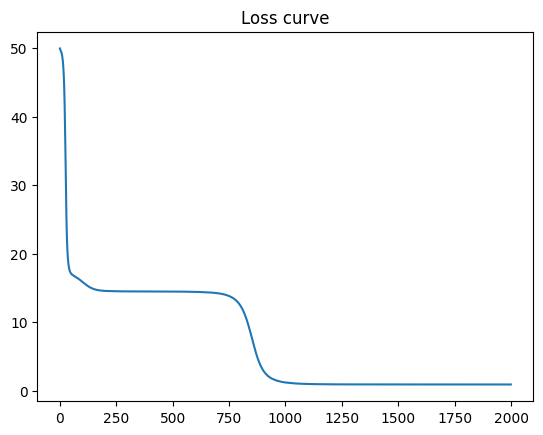

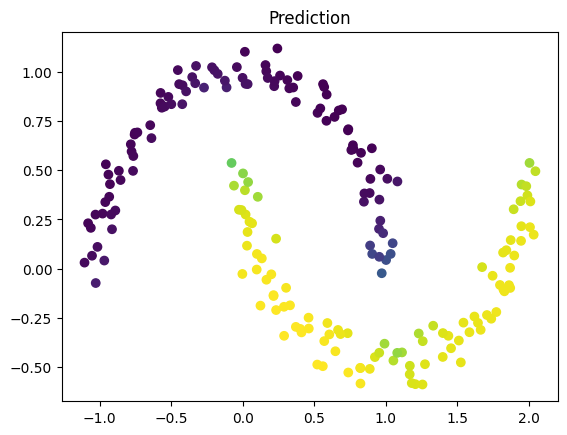

In [6]:
def BCELoss(pred, y):   
    ones = tensor.Tensor.fromNumpy(np.full(shape = pred.shape, fill_value=1.0), requiresGrad = False)
    eps = tensor.Tensor.fromNumpy(np.full(shape = pred.shape, fill_value=1e-3), requiresGrad = False)
    a = (pred + eps).log()
    a.data = np.where(np.isnan(a.data), -100, np.clip(a.data, -100, np.inf))
    b = (ones-pred+eps).log()
    b.data = np.where(np.isnan(b.data), -100, np.clip(b.data, -100, np.inf))
    #print(a,b)
    return (-(y * a + (ones-y) * b)).sum()

linear = nn.Linear(shapeIn=2, shapeOut=10)
linear2 = nn.Linear(shapeIn=10, shapeOut=20)
linear3 = nn.Linear(shapeIn=20, shapeOut=1)

optimizer = optim.SGD(params=linear.parameters() + linear2.parameters() + linear3.parameters(), momentum=0.4, lr=1e-3)
nEpoch = 2000
lossHist = []
for i in range(nEpoch):
    optimizer.zeroGrad()
    pred = linear3(linear2(linear(X).relu()).relu()).sigmoid()
    loss = ((y-pred)**2).sum()
    #loss = BCELoss(pred, y)
    lossHist.append(loss.numpy())
    loss.backward()
    optimizer.step()

plt.plot(lossHist);plt.title('Loss curve');

pred = linear3(linear2(linear(X).relu()).relu()).sigmoid()
acc = (pred.data.round() == y.data).sum()/y.shape[0]

print(f"Accuracy: {acc}")
plt.figure(); plt.scatter(x=X.numpy()[:,0], y=X.numpy()[:,1], c=pred.numpy()); plt.title('Prediction');

Accuracy: 1.0


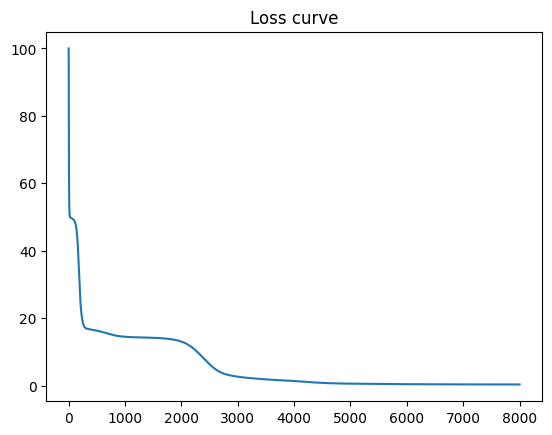

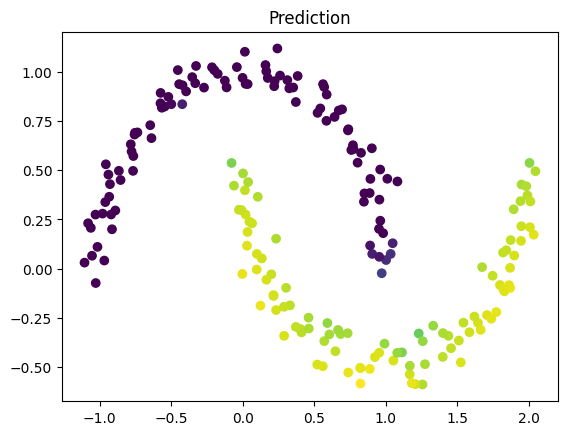

In [7]:
hidden = [2,50,100,1]
act = [ops.ReLU,ops.ReLU,ops.ReLU,ops.Sigmoid]
mlp = nn.MLP(hiddenDim = hidden, activations = act)
optimizer = optim.SGD(params=mlp.parameters(), lr=1e-4)
nEpoch = 8000
lossHist = []
for i in range(nEpoch):
    optimizer.zeroGrad()
    pred = mlp(X)
    loss = ((y-pred)**2).sum()
    #loss = BCELoss(pred,y)
    lossHist.append(loss.numpy())
    loss.backward()
    optimizer.step()

plt.plot(lossHist);plt.title('Loss curve');

pred = mlp(X)
acc = (pred.data.round() == y.data).mean()

print(f"Accuracy: {acc}")
plt.figure(); plt.scatter(x=X.numpy()[:,0], y=X.numpy()[:,1], c=pred.numpy()); plt.title('Prediction');

## Plot computation graph

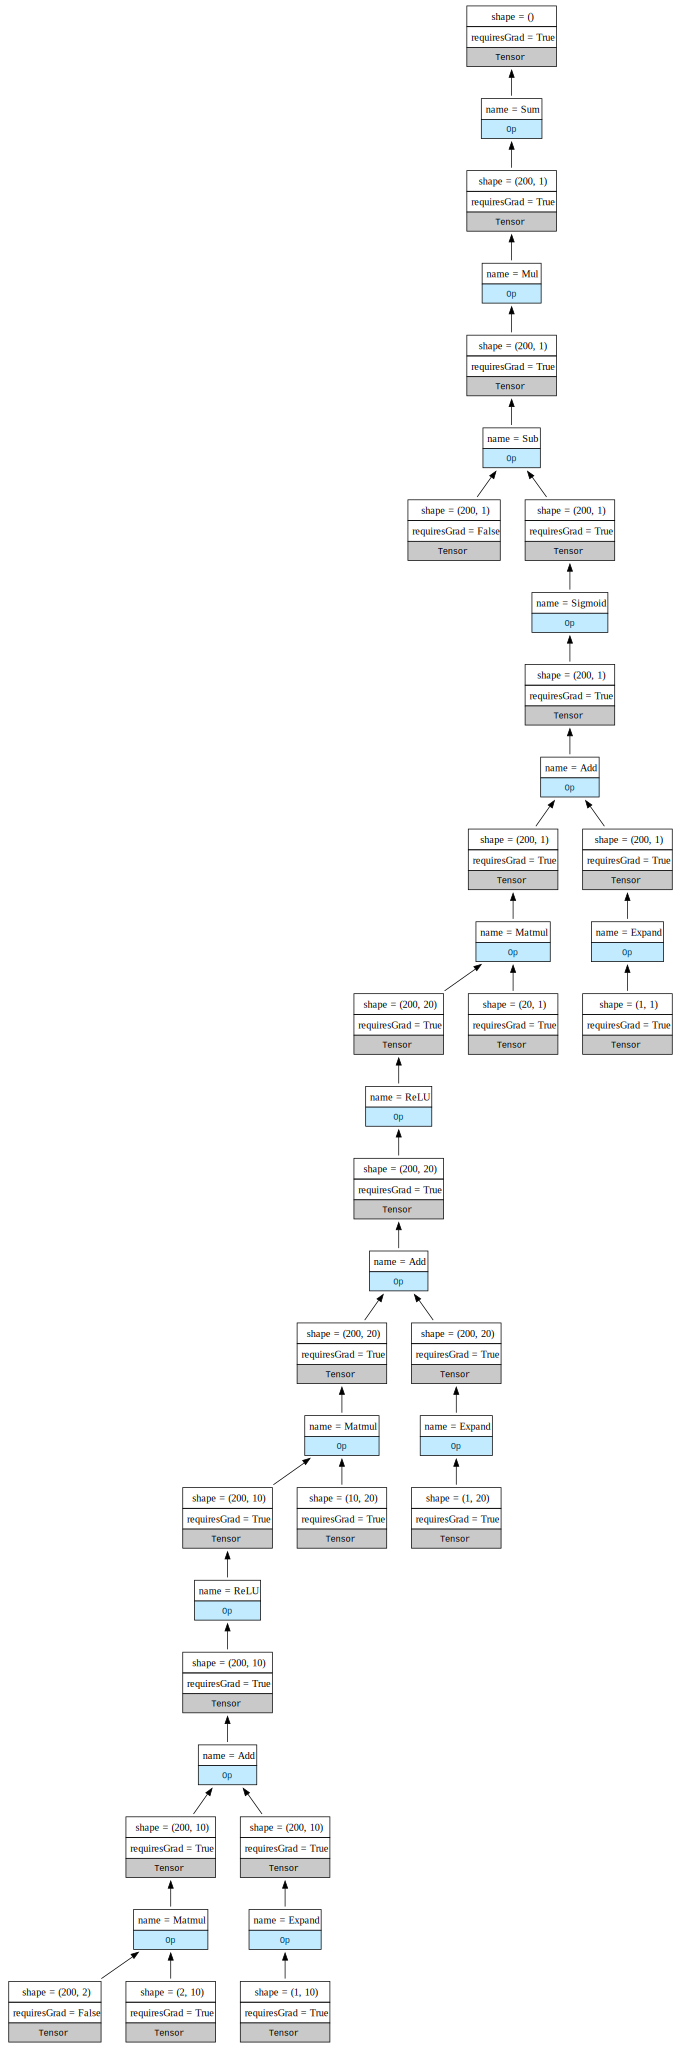

In [13]:
from juligrad import graph
graph.generateGraph(loss)